In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import root
from scipy.interpolate import CubicSpline
from scipy.signal import argrelextrema
from tabulate import tabulate
from scipy.optimize import curve_fit


def tikz_convert(ax,
         clean = False, mktex = False, path = "", filename = "", caption = None):
    
    num = len(ax.get_axes()) 
    if num != 1:
        num = 2
    
    if filename == "":
        import uuid
        filename = str(uuid.uuid4()) + ".tex"
        
    if path == "":
        path = "../Obsidian"
    
    if mktex:
    
        import tikzplotlib as tikz

        def tikzplotlib_fix_ncols(obj):
            """
            workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
            """
            if hasattr(obj, "_ncols"):
                obj._ncol = obj._ncols
            for child in obj.get_children():
                tikzplotlib_fix_ncols(child)

        tikzplotlib_fix_ncols(ax)
        if clean:
            ax = tikz.clean_figure(ax)
        
        tikz.save(f"{path}/{filename}", 
                axis_width = f"\\textwidth/{num} - 2cm",
                axis_height = "9cm")
    if caption:
        print(f"""
```text
\\begin{{figure}}[H]
\\centering
[[{filename}]]
\\caption({caption})
\\end{{figure}}
```""")
    else:
        print(f"""
```text
\\begin{{figure}}[H]
\\centering
[[{filename}]]
\\end{{figure}}
```""")
    
    return None


def read_dat(path):
    
    with open(path) as file:
        
        lines = file.readlines()
        headers = [str(x) for x in lines[0].strip().replace('"', '').replace(",",".").split("   ")]
        df = []
        for line in lines[1:]:
            df.append([float(x) for x in line.strip().replace('"', '').replace(",",".").split("   ")])
            
    df = pd.DataFrame(df)
    df.columns = ["sec","mA","mV"]
            
    return df

def auto_format(number):
    if isinstance(number, (int, float)):
        if abs(number) >= 1000 or (abs(number) < 0.001 and number != 0):
            return f"{number:.3e}"  # Экспоненциальный формат
        else:
            return f"{number:.3f}"  # Обычный формат
    return str(number)  # Если это не число, оставляем как есть

# Функция для форматирования DataFrame
def format_dataframe(df):
    return df.applymap(auto_format)


```text
\begin{figure}[H]
\centering
[[вольтамперная диаграмма для разных концентраций.tex]]
\end{figure}
```


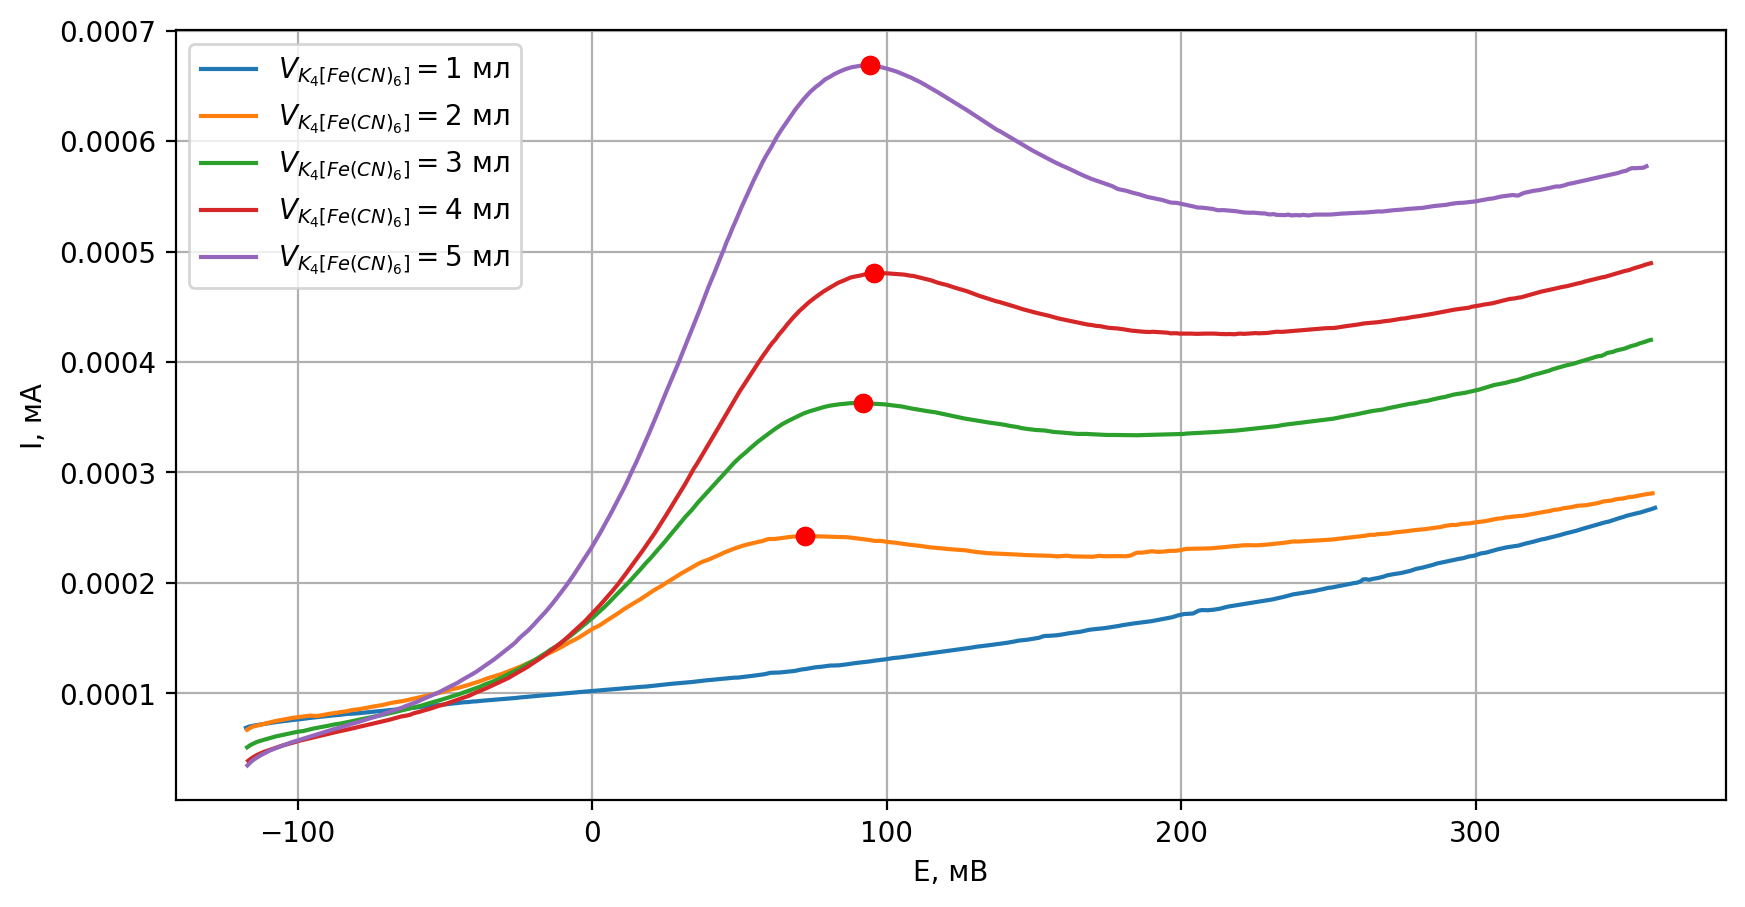

In [5]:
from scipy.signal import argrelextrema
from scipy.optimize import minimize_scalar

ax = plt.figure(figsize = (10,5),
          dpi = 200)
"""
path = "files/" + str(1) + ".dat"
df = read_dat(path)    
label = r"Фон"
plt.plot(df["mV"], df["mA"], label = label)
    """
    
    
mV = []
mA = []
maxes = []

for i in range(1,6):
    
    path = "files/" + str(i) + ".dat"
    df = read_dat(path)
    
    df = df[slice(20,1000)]


    #spline = CubicSpline(df["mV"].values, df["mA"].values)
    #x = np.linspace(-100,400)
    #plt.plot(x,-spline(x))
    #root = minimize_scalar(lambda x: -spline(x), [100,150])
    #plt.plot(root.x, root.fun, "o")
    #print(root, "\n")
    
    label = r"$V_{K_4[Fe(CN)_6]} = "+ str(i) + "$ мл"
    plt.plot(df["mV"], df["mA"],
            label = label)
    
    if i == 1: continue
    sli = slice(300, 450)
    max_val = df[df.mA == df.mA[sli].max()].iloc[0]
    maxes.append(max_val)
    plt.plot(np.linspace(1,1,10)*max_val.mV, np.linspace(1,1,10)*max_val.mA, 
            "o", color = "r")
    

plt.grid()
plt.xlabel("E, мВ")
plt.ylabel("I, мА")
#plt.xlim(-100,350)
#plt.ylim(0)
plt.legend()


tikz_convert(ax, clean = True, mktex = True, path = "", filename = "вольтамперная диаграмма для разных концентраций.tex")

sec    48.973000
mA     -0.000923
mV     27.403591
Name: 503, dtype: float64
sec     72.429000
mA       0.001153
mV     105.733131
Name: 764, dtype: float64
0.0007691714107181567 <- x в точке пересечения

0.00115317734889686

```text
\begin{figure}[H]
\centering
[[циклическая вольтамперограмма2.tex]]
\end{figure}
```


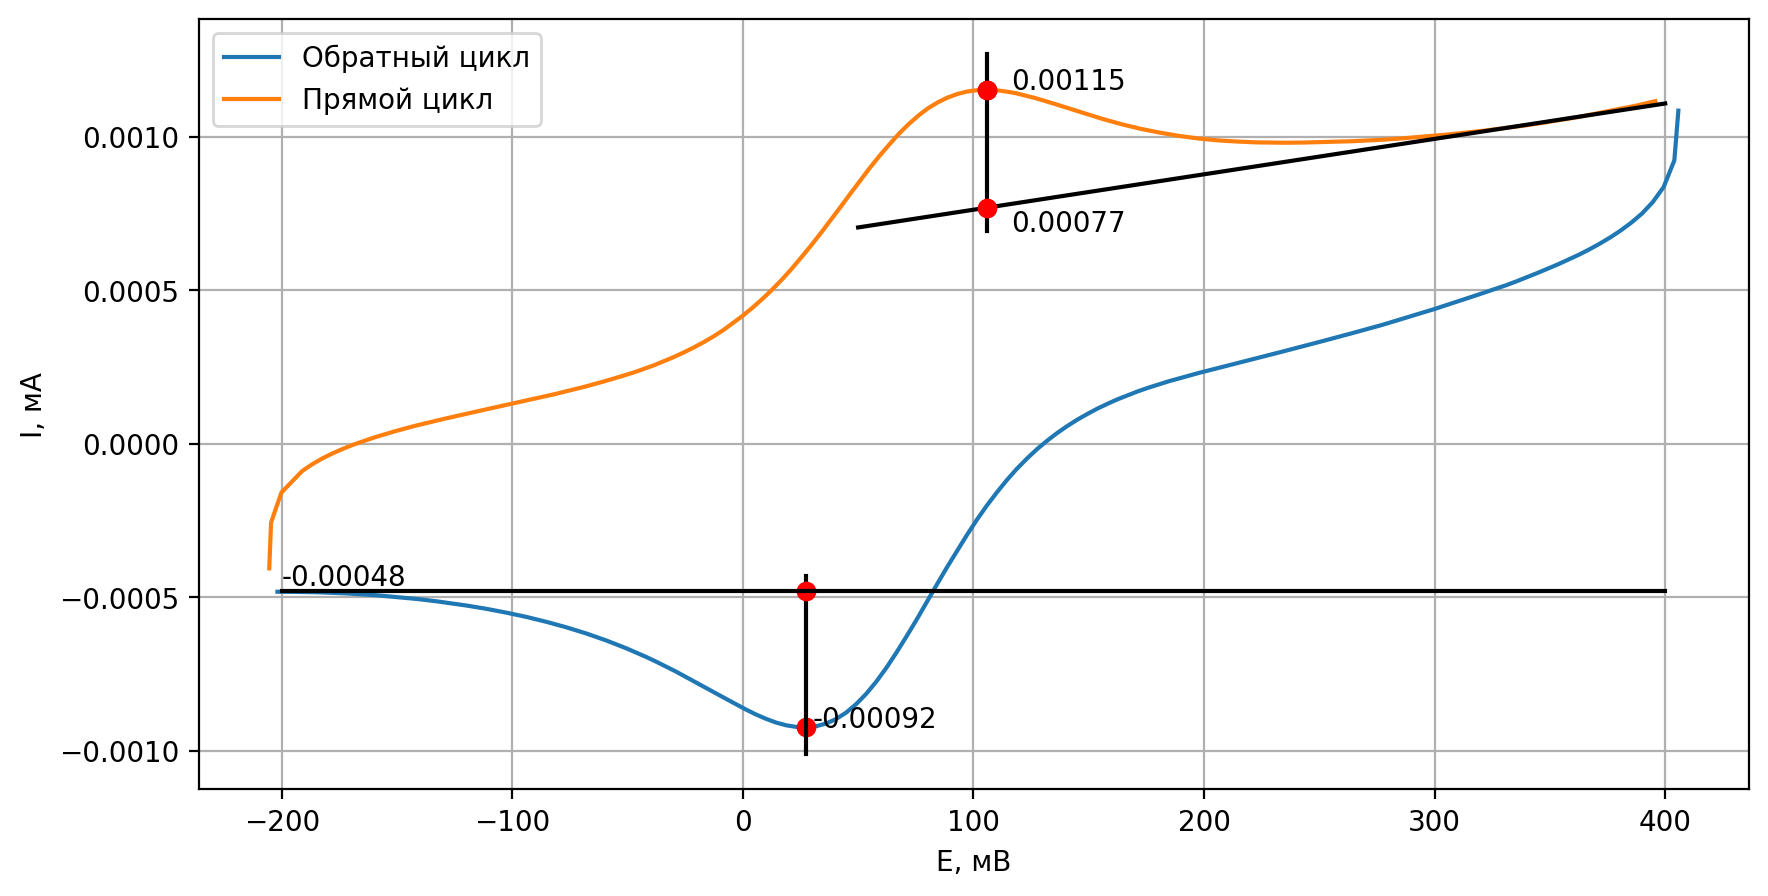

In [6]:
ax = plt.figure(figsize = (10,5),
          dpi = 200)

path = "files/cycle.dat"
df = read_dat(path)    




left = 322
right = 608

x = df["mV"][left:right]
y = df["mA"][left:right]
plt.plot(x, y, label = "Обратный цикл")
sli = slice(450, 608)
min_val = df[df.mA == df.mA[sli].min()].iloc[0]
print(min_val)
plt.text(min_val.mV*1.1, min_val.mA, str(np.round(min_val.mA,5))) 
plt.plot(np.linspace(1,1,10)*min_val.mV, np.linspace(1,1,10)*min_val.mA, 
            "o", color = "r")




left = 609
right = 910


### ПРЯМОЙ
x = df["mV"][left:right]
y = df["mA"][left:right]
plt.plot(x, y, label = "Прямой цикл")
sli = slice(left, right)

max_val = df[df.mA == df.mA[sli].max()].iloc[0]
plt.text(max_val.mV*1.1, max_val.mA, str(np.round(max_val.mA,5))) 
print(max_val)
plt.plot(np.linspace(1,1,10)*max_val.mV, np.linspace(1,1,10)*max_val.mA, 
            "o", color = "r")

plt.plot([27.4,27.4], [-0.00092*1.1, -0.00048*0.9], color = "black")
plt.plot(np.linspace(1,1,10)*27.4, np.linspace(1,1,10)*(-0.00048), 
            "o", color = "r")

(a, b) , pcov = curve_fit(lambda x, k, b: k*x + b, df.mV[slice(870,900)], df.mA[slice(870,900)])
plt.plot([50,400], [a*50+b,a*400+b], color = "black")
plt.text(max_val.mV*1.1, (max_val.mV*a+b)*0.9, str(np.round(max_val.mV*a+b,5)))
plt.plot([max_val.mV,max_val.mV], [(max_val.mV*a+b)*0.9, 1.1*max_val.mA], color = "black")
plt.plot(np.linspace(1,1,10)*max_val.mV, np.linspace(1,1,10)*(max_val.mV*a+b), 
            "o", color = "r")


#plt.plot([-200,400], [0.00098,0.00098], color = "black")
#plt.text(-200 , 0.001, "0.00098")

plt.plot(np.linspace(1,1,10)*max_val.mV, np.linspace(1,1,10)*max_val.mA, 
            "o", color = "r")

print(max_val.mV*a+b, "<- x в точке пересечения")

#plt.plot([-200,400], [0.00098,0.00098], color = "black")
plt.plot([-200,400], [-0.00048,-0.00048], color = "black")
plt.text(-200, -0.00046, "-0.00048")

print()
    
print(np.max(y))
plt.grid()
plt.xlabel("E, мВ")
plt.ylabel("I, мА")
#plt.xlim(-205, 400)
plt.legend()

tikz_convert(ax, clean = True, mktex = True, path = "", filename = "циклическая вольтамперограмма2.tex")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



```text
\begin{figure}[H]
\centering
[[все циклы.tex]]
\end{figure}
```


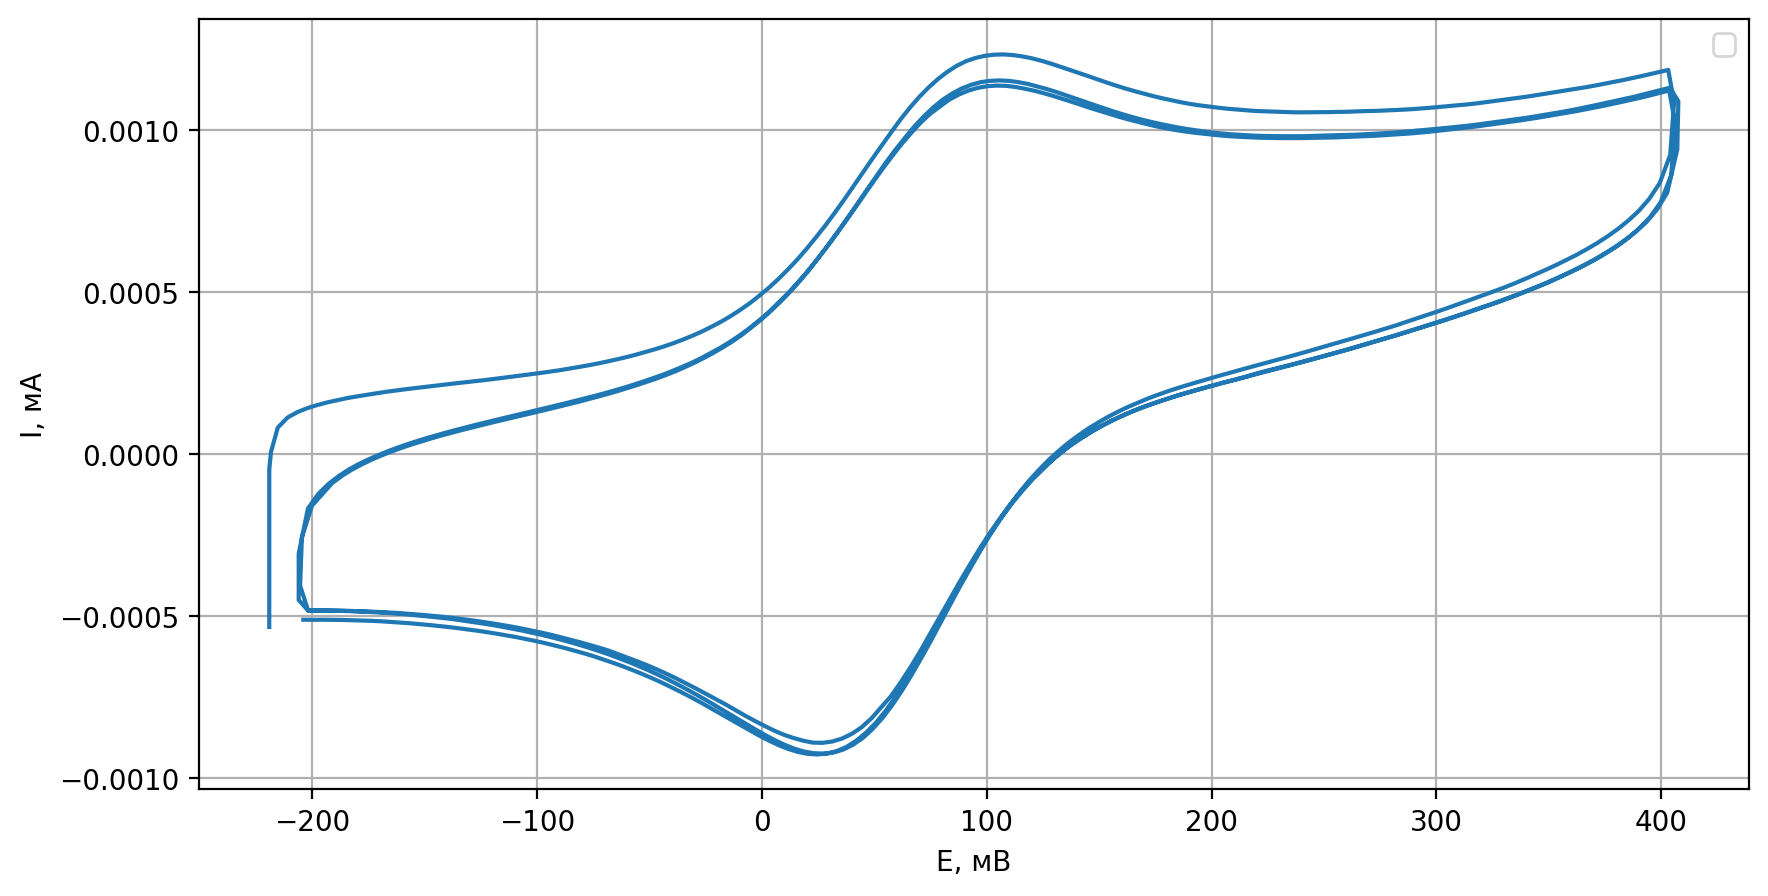

In [7]:
path = "files/cycle.dat"
df = read_dat(path) 

ax = plt.figure(figsize = (10,5), dpi = 200)
plt.plot(df.mV,df.mA)
plt.grid()
plt.xlabel("E, мВ")
plt.ylabel("I, мА")
#plt.xlim(-205, 400)
plt.legend()

tikz_convert(ax, mktex = True, filename = "все циклы.tex")

        sec        mA         mV
405  44.288  0.000242  72.129433
446  47.969  0.000363  92.007584
453  48.588  0.000480  95.872810
453  48.573  0.000668  94.216209
[1. 2. 3. 4.]
[1. 2. 3. 4.]
|     |   t, с |     I, мА |   E, mВ |
|-----|--------|-----------|---------|
| 405 | 44.288 | 0.0002423 |  72.129 |
| 446 | 47.969 | 0.000363  |  92.008 |
| 453 | 48.588 | 0.0004803 |  95.873 |
| 453 | 48.573 | 0.0006685 |  94.216 |

```text
\begin{figure}[H]
\centering
[[градуировочный график высоты пиков от концентрации.tex]]
\end{figure}
```


/tmp/ipykernel_5394/2585178458.py:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(auto_format)


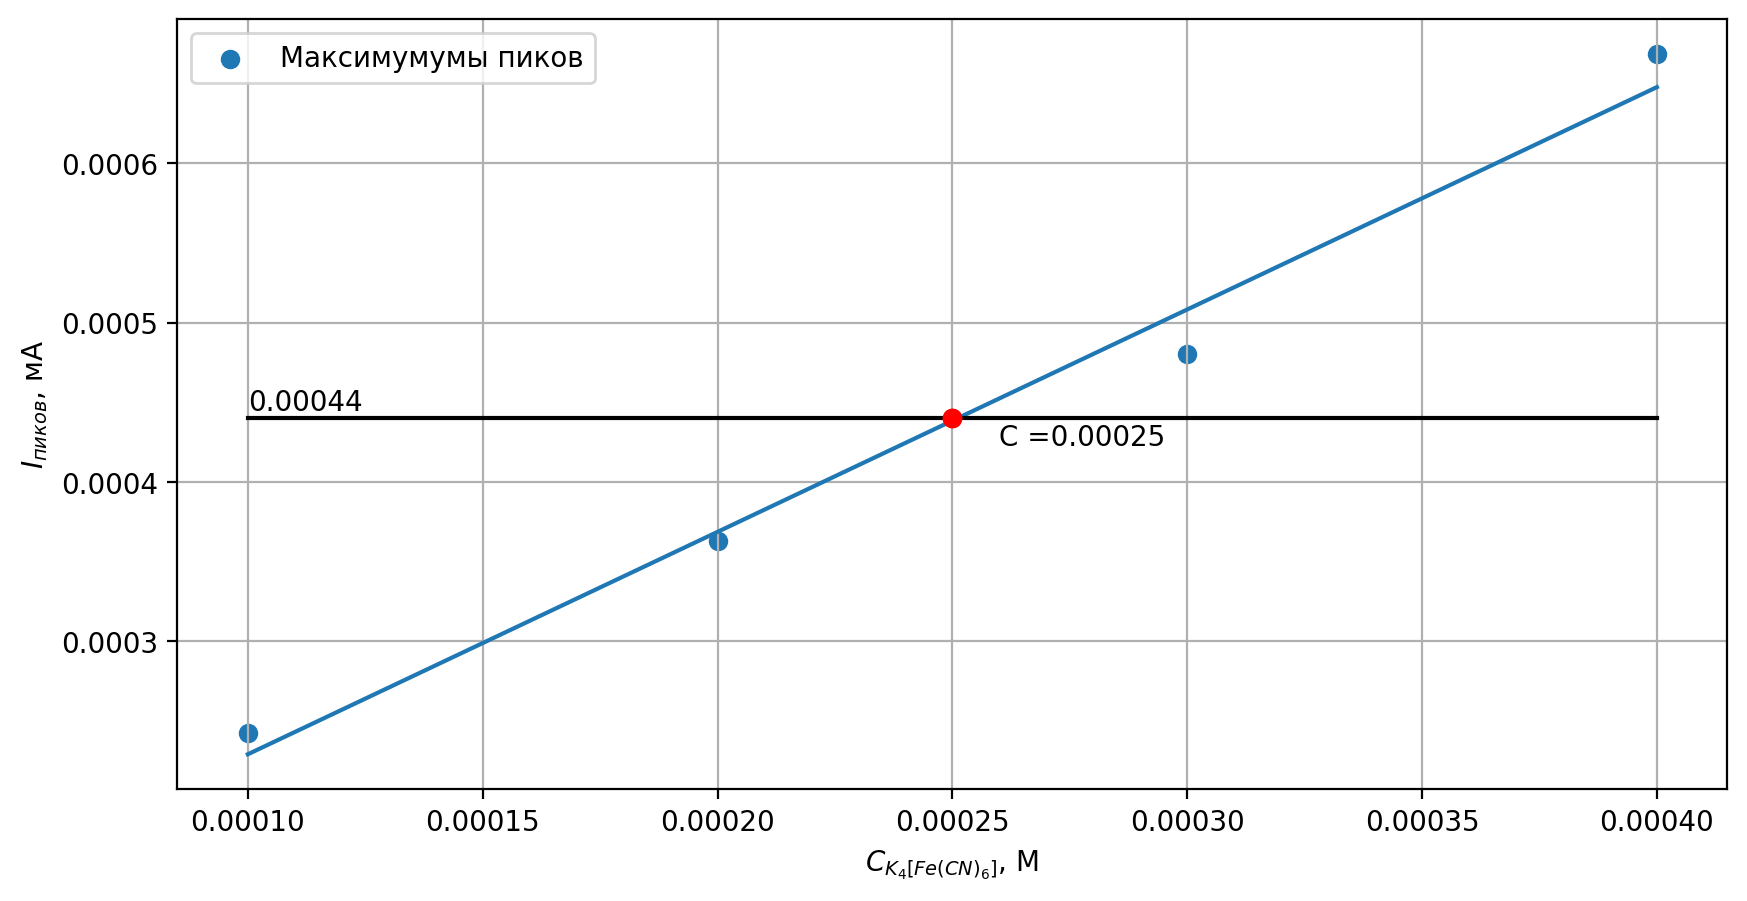

In [21]:
from scipy.optimize import curve_fit

maxes = pd.DataFrame(maxes)#.sort_values(by = 'mV')
print(maxes)



popt, pcov = curve_fit(lambda x, k, b: k*x+b, np.linspace(1,4,4)*0.005/50, maxes.mA)
print(np.linspace(1,4,4))



x = np.linspace(1,4,4)*0.005/50
print(np.linspace(1,4,4))

ax = plt.figure(figsize = (10,5), dpi = 200)
plt.scatter(x, maxes.mA, label = "Максимумумы пиков")
plt.plot(x,
        popt[0]*x + popt[1])
plt.plot([0.005/50,4*0.005/50], [0.00044, 0.00044], color = "black")
plt.text(0.005/50, 0.000445, "0.00044")
plt.plot(np.ones(3)*0.00025, np.ones(3)*0.00044, "o", color ='r')
plt.text(0.00026, 0.000423, "C =" + str(0.00025))
plt.grid()
plt.xlabel("$C_{K_4[Fe(CN)_6]}$, М")
plt.ylabel("$I_{пиков}$, мА")
plt.legend()


print(tabulate(format_dataframe(maxes), headers = ["t, с", "I, мА", "E, mВ"], tablefmt = 'github'))

tikz_convert(ax, mktex = True, filename = "градуировочный график высоты пиков от концентрации.tex")